In [7]:
import numpy as np  # matrices y vectores
import matplotlib.pyplot as plt #gráfica
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [36]:
#Cargamos los datos
data = pd.read_csv("data/medellin.csv")

data = data.drop(columns=['is_new','property_id','min_price','company_name','client_type','latitude','longitude','zone'])
data = data[(data.property_type == 'Casa')|(data.property_type == 'Apartamento')]
data = data[data['rooms'] != 'Sin especificar']
data = data[data['baths'] != 'Sin especificar']
data['garages'] = data['garages'].replace('Sin especificar', 0)
data['garages'] = data['garages'].replace('Más de 10', 11)
data['area']=data['area'].astype('int64')
data['rooms']=data['rooms'].astype('int64')
data['garages']=data['garages'].astype('int64')
data['property_type']=data['property_type'].astype('category')
data['stratum']=data['stratum'].astype('category')
data['baths']=data['baths'].astype('int64')
data['price']=data['price'].astype('int64')
data['neighbourhood']=data['neighbourhood'].astype('category')
data['city']=data['city'].astype('category')

data

,area,rooms,garages,stratum,property_type,baths,price,neighbourhood,city
0,147,3,3,Estrato 6,Apartamento,5,1150000000,Castropol,Medellín
1,110,3,1,Estrato 5,Apartamento,2,580000000,Florida nueva,Medellín
2,81,3,1,Estrato 4,Apartamento,2,510000000,Calasanz,Medellín
3,100,4,2,Estrato 5,Apartamento,3,480000000,Loma del Escobero,Envigado
4,71,3,1,Estrato 4,Apartamento,2,390000000,Centro Asomadera N 2,Medellín
...,...,...,...,...,...,...,...,...,...
7738,124,3,0,Estrato 5,Apartamento,4,655000000,Loma de las brujas,Envigado
7739,95,3,1,Estrato 5,Apartamento,2,490000000,Simon bolivar,Medellín
7740,175,3,0,Estrato 6,Apartamento,3,790000000,Los balsos no.2,Medellín
7741,114,3,1,Estrato 5,Apartamento,3,665000000,Laureles,Medellín


In [ ]:
scaler = MinMaxScaler()
data['area'] = scaler.fit_transform(data[['area']])
data['rooms'] = scaler.fit_transform(data[['rooms']])
data['garages'] = scaler.fit_transform(data[['garages']])
data['baths'] = scaler.fit_transform(data[['baths']])

In [ ]:
#Se crean dummies a las variables predictoras categóricas (no a la variable obj)
data = pd.get_dummies(data, columns=['is_new'], drop_first=True)
data = pd.get_dummies(data, columns=['stratum'], drop_first=False)
data = pd.get_dummies(data, columns=['property_type'], drop_first=False)
data = pd.get_dummies(data, columns=['neighbourhood'], drop_first=False)
data = pd.get_dummies(data, columns=['city'], drop_first=True)

data.head()

,area,rooms,garages,baths,price,stratum_Campestre,stratum_Estrato 0,stratum_Estrato 1,stratum_Estrato 2,stratum_Estrato 3,...,city_Medellín,city_Otros Municipios,city_Otros municipios,city_Rionegro,city_Sabaneta,city_San Antonio de Prado,city_San Jerónimo,city_Santa Elena,city_Santa Fé de Antioquia,city_Sopetran
0,147,3,3,5,1150000000,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,110,3,1,2,580000000,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,81,3,1,2,510000000,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,100,4,2,3,480000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,71,3,1,2,390000000,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
#División 70-30
from sklearn.model_selection import train_test_split
X = data.drop("price", axis = 1) # Variables predictoras
Y = data['price'] #Variable objetivo
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3) #Muestreo estratificado

In [ ]:
#Creación del modelo con el conjunto de entrenamiento
from sklearn.tree import DecisionTreeRegressor
modelTree = DecisionTreeRegressor(criterion='friedman_mse', min_samples_leaf=2, max_depth=None)
modelTree.fit(X_train, Y_train) #70% train

DecisionTreeRegressor(criterion='friedman_mse', min_samples_leaf=2)

<ipython-input-77-d05947049ba0>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()],'k--', color = 'black', lw=2)


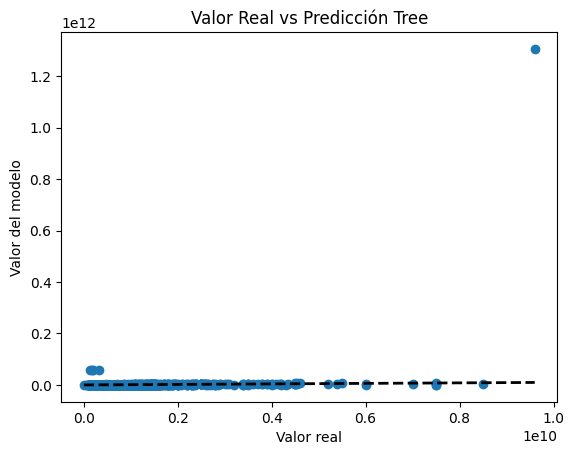

In [ ]:
#Evaluación del árbol 30%
from sklearn import metrics
Y_pred = modelTree.predict(X_test) #30%

#Dataframe para comparar los resultados
medidas= pd.DataFrame(index=['mse','rmse','mae','mape','max'])

mse = metrics.mean_squared_error(Y_test,Y_pred)
rmse = np.sqrt(mse)
mae= metrics.mean_absolute_error(Y_test,Y_pred)
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred)
max=metrics.max_error(Y_test,Y_pred)
medidas['Arbol']=[mse, rmse, mae, mape,max]
print(medidas)

#Gráfica Valor Real vs Predicción
plt.scatter(Y_test, Y_pred)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()],'k--', color = 'black', lw=2)
plt.xlabel('Valor real')
plt.ylabel('Valor del modelo')
plt.title('Valor Real vs Predicción Tree')
plt.show() # Mostrar la grafica luego de que ya se definio todos los elementos

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
model_Knn =KNeighborsRegressor(n_neighbors=3,metric='euclidean')
model_Knn.fit(X_train, Y_train) #70% train

KNeighborsRegressor(metric='euclidean', n_neighbors=3)

             Arbol           Knn
mse   8.244144e+20  1.227302e+21
rmse  2.871262e+10  3.503287e+10
mae   9.447490e+08  1.910833e+09
mape  1.014941e+00  1.974283e+00
max   1.296400e+12  8.676900e+11


<ipython-input-76-4032d902f59d>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()],'k--', color = 'black', lw=2)


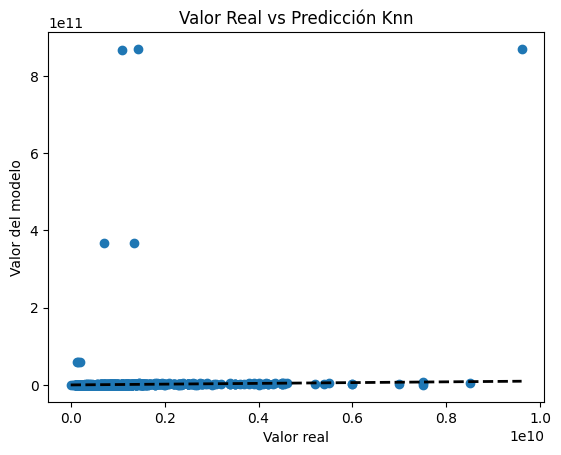

In [ ]:
from sklearn import metrics

Y_pred = model_Knn.predict(X_test) #30%

#Medidas de error
mse = metrics.mean_squared_error(Y_test,Y_pred)
rmse = np.sqrt(mse)
mae= metrics.mean_absolute_error(Y_test,Y_pred)
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred)
max=metrics.max_error(Y_test,Y_pred)
medidas['Knn']=[mse, rmse, mae, mape,max]
print(medidas)

#Gráfica Valor Real vs Predicción
plt.scatter(Y_test, Y_pred)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()],'k--', color = 'black', lw=2)
plt.xlabel('Valor real')
plt.ylabel('Valor del modelo')
plt.title('Valor Real vs Predicción Knn')
plt.show()

In [ ]:
from sklearn.neural_network import MLPRegressor
model_RN = MLPRegressor(activation="relu",hidden_layer_sizes=(4),learning_rate='constant',
                        learning_rate_init=0.2, momentum = 0.3, max_iter=500)
model_RN.fit(X_train, Y_train) #70% train

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=4, learning_rate_init=0.2, max_iter=500,
             momentum=0.3)

             Arbol                      NN
mse   8.244144e+20  1.1109882663956023e+18
rmse  2.871262e+10       1054034281.413846
mae   9.447490e+08        693261445.068803
mape  1.014941e+00                0.916139
max   1.296400e+12       9568931195.640881


<ipython-input-81-3c69a2bfd53f>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()],'k--', color = 'black', lw=2)


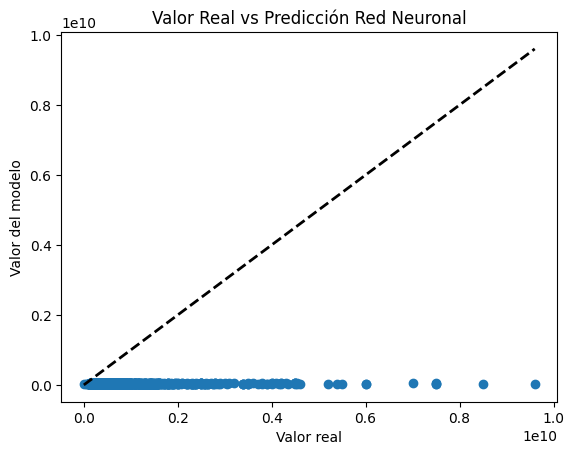

In [ ]:
#Evaluación de NN
from sklearn import metrics

Y_pred = model_RN.predict(X_test) #30%

#Medidas de error
mse = metrics.mean_squared_error(Y_test,Y_pred)
rmse = np.sqrt(mse)
mae= metrics.mean_absolute_error(Y_test,Y_pred)
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred)
max=metrics.max_error(Y_test,Y_pred)
medidas['NN']=[format(mse), rmse, mae, mape,max]
print(medidas)

#Gráfica Valor Real vs Predicción
plt.scatter(Y_test, Y_pred)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()],'k--', color = 'black', lw=2)
plt.xlabel('Valor real')
plt.ylabel('Valor del modelo')
plt.title('Valor Real vs Predicción Red Neuronal')
plt.show()

In [ ]:
import pickle
filename = 'modelo.pkl'
variables= X.columns._values
pickle.dump([modelTree,variables], open(filename, 'wb'))

#pickle.dump([modelTree,modelKnn, modelNN,modelSVM, labelencoder,variables,min_max_scaler], open(filename, 'wb'))